In [1]:
%matplotlib inline

Expressibility-trainability tradeoff {#barren_plateaus}
==========================================

*Author: Cichy Simon (simon.cichy\@vertrauen.pro).

Reproducing some of the results presented in Holmes et al. (2021)  
Based on the demo on Barren plateaus in quantum neural networks  
With further inspiration from the demo on the Variational classifier  

Exploring the barren plateau problem with PennyLane
---------------------------------------------------

First, we import PennyLane, NumPy, and Matplotlib


In [2]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

Defining the random circuit that will be used to observe the Barren plateau phenomenon. 
Starting with a hardware efficient ansatz with a variable number of layers.

In [3]:
# Set a seed for reproducibility
np.random.seed(42)


def rand_circuit(params, random_gate_sequence=None, num_qubits=None, num_layers=None):
    """A random variational quantum circuit.

    Args:
        params (array[float]): array of parameters
        random_gate_sequence (dict): a dictionary of random gates
        num_qubits (int): the number of qubits in the circuit

    Returns:
        float: the expectation value of the target observable
    """
    # Initial rotations on all qubits
    for i in range(num_qubits):             # rotate all qubits
        qml.RY(np.pi / 4, wires=i)          # "to prevent X, Y , or Z from being an especially preferential 
                                            # direction with respect to gradients."

    # Repeating a layer structure
    for l in range(num_layers):
        # Single random gate layer (single qubit rotations)
        for i in range(num_qubits):
            random_gate_sequence[l][i](params[l][i], wires=i)
        # Nearest neighbour controlled phase gates
        if num_qubits > 1:                          # no entangling gates if using a single qubit
            for i in range(num_qubits - 1):
                qml.CZ(wires=[i, i + 1])
            if num_qubits > 2:                      # avoid 2 CZ gates on the same wires
                qml.CZ(wires=[num_qubits-1, 0])

    # Objective operator H = Z_1 Z_2
    H = np.zeros((2 ** num_qubits, 2 ** num_qubits))
    H[0, 0] = 1                                         # why? Does it correspond to the paper?
    wirelist = [i for i in range(num_qubits)]
    return qml.expval(qml.Hermitian(H, wirelist))       # How does that work?

Evaluate the gradient for more qubits
=====================================

We can repeat the above analysis with increasing number of qubits.


2  layers
3  layers


WireError: Did not find some of the wires (0,) on device with wires (tensor(2, requires_grad=True),).

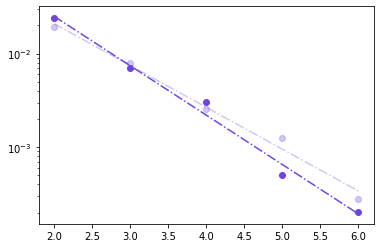

In [5]:
num_samples = 200
gate_set = [qml.RX, qml.RY, qml.RZ]
qubits = [2, 3, 4, 5, 6]
layers = [2, 3]
colours = ['#6f45d8', '#4547d8', '#45ccd8', '#45d859', '#c2d845', '#d89d45', '#d85645']


for num_layers in layers:
    variances = [[], []]
    print(num_layers, " layers")

    for num_qubits in qubits:
        grad_vals = [[], []]

        for i in range(num_samples):
            dev = qml.device("default.qubit", wires=num_qubits)
            qcircuit = qml.QNode(rand_circuit, dev)
            grad = qml.grad(qcircuit, argnum=0)

            random_gate_sequence = [[np.random.choice(gate_set) for _ in range(num_qubits)] for _ in range(num_layers)]
            params = np.random.uniform(0, np.pi, size=(num_layers, num_qubits))

            gradient = grad(
                params, random_gate_sequence=random_gate_sequence, num_qubits=num_qubits, num_layers=num_layers
            )
            grad_vals[0].append(gradient[0][0])
            grad_vals[1].append(gradient[-1][-1])
        variances[0].append(np.var(grad_vals[0]))
        variances[1].append(np.var(grad_vals[1]))


    variances = np.array(variances)
    qubits = np.array(qubits)

    # Fit the semilog plot to a straight line
    p1 = np.polyfit(qubits, np.log(variances[0]), 1)
    p2 = np.polyfit(qubits, np.log(variances[1]), 1)

    # Plot the straight line fit to the semilog
    plt.semilogy(qubits, np.exp(p1[0] * qubits + p1[1]), "-.", c=colours[0])
    plt.semilogy(qubits, np.exp(p2[0] * qubits + p2[1]), "-.", c=colours[0], alpha=0.3)
    plt.semilogy(qubits, variances[0], "o", c=colours[0], label="{} layers - slope {:3.2f}".format(num_layers, p1[0]))
    plt.semilogy(qubits, variances[1], "o", c=colours[0], alpha=0.3, label="{} layers - slope {:3.2f}".format(num_layers, p2[0]))


plt.xlabel(r"N Qubits")
plt.ylabel(r"$\langle \partial \theta_{1, 1} E\rangle$ variance")
plt.legend()
plt.show()

References
==========

1.  McClean, Jarrod R., et al., Barren plateaus in quantum neural
    network training landscapes. Nature communications 9.1 (2018): 4812.
2.  Holmes, Zoë, et al., Connecting ansatz expressibility to gradient 
    magnitudes and barren plateaus. arXiv:2101.02138
3.  Shahawaz, Ahmed, Barren plateaus in quantum neural networks 
    (https://pennylane.ai/qml/demos/tutorial_barren_plateaus.html)
4.  PennyLane dev team, Variational Calssifier 
    (https://pennylane.ai/qml/demos/tutorial_variational_classifier.html#fitting-the-parity-function)

